# ADS 509 Sentiment Assignment

This notebook holds the Sentiment Assignment for Module 6 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required. 

In a previous assignment you put together Twitter data and lyrics data on two artists. In this assignment we apply sentiment analysis to those data sets. If, for some reason, you did not complete that previous assignment, data to use for this assignment can be found in the assignment materials section of Blackboard. 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [2]:
import os
import re
import emoji
import pandas as pd
import numpy as np

from collections import Counter, defaultdict
from string import punctuation

from nltk.corpus import stopwords

sw = stopwords.words("english")

In [3]:
# Add any additional import statements you need here
import nltk
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
import copy
import matplotlib as plt
from collections import Counter
from matplotlib import pyplot as plt

from string import punctuation
import string


In [4]:
# change `data_location` to the location of the folder on your machine.
data_location = "/Users/summerpurschke/Desktop/ADS/ADS509/Mod2"

# These subfolders should still work if you correctly stored the 
# data from the Module 1 assignment
twitter_folder = "/twitter/"
lyrics_folder = "/lyrics"

positive_words_file = "positive-words.txt"
negative_words_file = "negative-words.txt"
tidy_text_file = "tidytext_sentiments.txt"

## Data Input

Now read in each of the corpora. For the lyrics data, it may be convenient to store the entire contents of the file to make it easier to inspect the titles individually, as you'll do in the last part of the assignment. In the solution, I stored the lyrics data in a dictionary with two dimensions of keys: artist and song. The value was the file contents. A Pandas data frame would work equally well. 

For the Twitter data, we only need the description field for this assignment. Feel free all the descriptions read it into a data structure. In the solution, I stored the descriptions as a dictionary of lists, with the key being the artist. 




In [6]:
# Read in the lyrics data
def create_lyrics_dictionary(folder_path):
    lyrics_dict = {}

    # Iterate over each item in the folder
    for item_name in os.listdir(folder_path):
        item_path = os.path.join(folder_path, item_name)

        # Check if the item is a folder (artist folder)
        if os.path.isdir(item_path):
            artist_dict = {}

            # Iterate over each file in the artist folder
            for filename in os.listdir(item_path):
                file_path = os.path.join(item_path, filename)

                # Check if the item is a file (song file)
                if os.path.isfile(file_path):
                    with open(file_path, "r") as file:
                        # Read the contents of the file
                        lines = file.readlines()

                        if lines:
                            title = lines[0].strip()  # Assuming the first line contains the title
                            lyrics = ''.join(lines[1:])  # Combine the remaining lines as the lyrics

                            # Add the song lyrics to the artist's dictionary with the title as the inner key
                            artist_dict[title] = lyrics

            # Add the artist's dictionary to the main lyrics dictionary
            lyrics_dict[item_name] = artist_dict

    return lyrics_dict

# Call the function with the lyrics folder path
lyrics_dictionary = create_lyrics_dictionary(data_location + lyrics_folder)

In [7]:
# Read in the twitter data

twitter_files = os.listdir(data_location + twitter_folder)
desc_files = [f for f in twitter_files if "followers_data" in f]
twitter_data = defaultdict(list)
for f in desc_files :
    artist = f.split("_")[0]
        
    with open(data_location + twitter_folder + f,'r', encoding='utf-8') as infile :
        next(infile)
        for idx, line in enumerate(infile.readlines()) :
            line = line.strip().split("\t")
            if len(line) == 7 :
                twitter_data[artist].append(line[6])

twitter_data = dict(twitter_data)

In [ ]:
# Read in the positive and negative words and the
# tidytext sentiment. Store these so that the positive
# words are associated with a score of +1 and negative words
# are associated with a score of -1. You can use a dataframe or a 
# dictionary for this.

In [12]:
# Read in positive words
positive_words = pd.read_csv("positive-words.txt", header=None, comment=";", encoding='latin-1')
positive_words.columns = ["word"]
positive_words["sentiment"] = 1

# Read in negative words
negative_words = pd.read_csv("negative-words.txt", header=None, comment=";", encoding='latin-1')
negative_words.columns = ["word"]
negative_words["sentiment"] = -1

# Read in tidytext sentiment
tidytext_sentiment = pd.read_csv("tidytext_sentiments.txt", sep="\t")
tidytext_sentiment = tidytext_sentiment.replace('negative', -1)
tidytext_sentiment = tidytext_sentiment.replace('positive', 1)

# # Combine positive, negative, and tidytext sentiment into a single dataframe or dictionary
sentiment_scores = pd.concat([positive_words, negative_words, tidytext_sentiment])
sentiment_scores.reset_index(drop=True, inplace=True)

# Drop duplicate values 
sentiment_scores = sentiment_scores.drop(columns = 'lexicon').drop_duplicates()

## Sentiment Analysis on Songs

In this section, score the sentiment for all the songs for both artists in your data set. Score the sentiment by manually calculating the sentiment using the combined lexicons provided in this repository. 

After you have calculated these sentiments, answer the questions at the end of this section.


Clean the lyrics data 

In [13]:
punctuation = set(punctuation) # speeds up comparison

# Define function for removing punctuation from dictionary 
def clean_text(text):
    cleaned_text = text.translate(str.maketrans("", "", string.punctuation))
    return cleaned_text

# Initiate a new dictionary that is empty - will add cleaned data as it's processed 
lyrics_dictionary_cleaned = {}

# Fold to lowercase and populate lyrics_dictionary_cleaned
for artist, songs in lyrics_dictionary.items():
    cleaned_songs = {}
    for song, lyrics in songs.items():
        cleaned_lyrics = lyrics.lower()
        cleaned_songs[song] = cleaned_lyrics
    lyrics_dictionary_cleaned[artist] = cleaned_songs

# Remove stopwords directly from lyrics_dictionary_cleaned
for artist, songs in lyrics_dictionary_cleaned.items():
    for song, lyrics in songs.items():
        # Split the lyrics into individual words
        words = lyrics.split()
        # Remove stopwords from the list of words
        cleaned_words = [word for word in words if word.lower() not in sw]
        # Join the cleaned words back into a single string
        cleaned_lyrics = " ".join(cleaned_words)
        # Update the lyrics in the lyrics_dictionary_cleaned
        lyrics_dictionary_cleaned[artist][song] = cleaned_lyrics

# Remove punctuation directly from lyrics_dictionary_cleaned
for artist, songs in lyrics_dictionary_cleaned.items():
    cleaned_songs = {}
    for song, lyrics in songs.items():
        # Remove punctuation marks
        cleaned_lyrics = lyrics.translate(str.maketrans("", "", string.punctuation))
        cleaned_songs[song] = cleaned_lyrics
    lyrics_dictionary_cleaned[artist] = cleaned_songs

# split at whitespace 
for artist, songs in lyrics_dictionary_cleaned.items():
    for song, lyrics in songs.items():
        split_lyrics = lyrics.split()
        lyrics_dictionary_cleaned[artist][song] = split_lyrics


Calculate the sentiment scores for each song

In [14]:
# Intialize an empty dictionary 
sentiment_dict = {}

# Iterate over the artists in the lyrics_dictionary_cleaned
for artist, songs in lyrics_dictionary_cleaned.items():
    # Create a nested dictionary for the artist if it doesn't exist in the result dictionary
    if artist not in sentiment_dict:
        sentiment_dict[artist] = {}
    
    # Iterate over the songs for the artist
    for song, tokens in songs.items():
        # Initialize the sum for the current song - will add from here 
        song_sum = 0
        
        # Iterate over the tokens in the song
        for token in tokens:
            # Check if the token exists in the sentiment_scores dataframe
            if token in sentiment_scores['word'].values:
                # Get the sentiment value associated with the token
                sentiment_value = sentiment_scores[sentiment_scores['word'] == token]['sentiment'].values[0]
                # Add the sentiment value to the song_sum
                song_sum += sentiment_value
        
        # Assign the song_sum to the result dictionary
        sentiment_dict[artist][song] = song_sum

Create a dataframe of values for each song 

In [ ]:
# Create an empty list to store the flattened data
flattened_data = []

# Iterate over the outer keys (artists) in the result dictionary
for artist, songs in sentiment_dict.items():
    # Iterate over the inner keys (songs) in each artist's songs
    for song, value in songs.items():
        # Append the artist, song, and value as a tuple to the flattened_data list
        flattened_data.append((artist, song, value))

# Create a dataframe from the flattened_data list
sentiment_df = pd.DataFrame.from_records(flattened_data, columns=['Artist', 'Song', 'Value'])

### Questions
Q: Overall, which artist has the higher average sentiment per song? 

A: Robyn has a higher average sentiment per song at 8.96 compared to 5.57. 

---

In [ ]:
robyn_avg_sentiment = sentiment_df[sentiment_df['Artist'] == 'robyn']['Value'].mean()
cher_avg_sentiment = sentiment_df[sentiment_df['Artist'] == 'cher']['Value'].mean()

print(f'Cher songs have an average sentient of {round(cher_avg_sentiment,2)}')
print(f'Robyn songs have an average sentient of {round(robyn_avg_sentiment,2)}')

Cher songs have an average sentient of 5.57
Robyn songs have an average sentient of 8.96


Q: For your first artist, what are the three songs that have the highest and lowest sentiments? Print the lyrics of those songs to the screen. What do you think is driving the sentiment score? 

A: 

Lowest Sentiments (in order):

- Don't Fucking Tell me What To Do: This song is says killing in just about every line, which is probably driving the score.
- Criminal Intent: This song is about partaking illegal activities (intentionally). 
- Love Kills: This song isn't as negative as the others in my opinion when reading through it, it's a song about the hardships of love which a lot of other artists have written about. However from a sentiment point of view, it has the word 'kill' often, though it is preceded by 'love' most of the times that I can see which likely balances out. It does however use words like protect, conceal, wreck, and cold which likely contribute to the negative score. 



In [ ]:
# Create a list of the three lowest sentiment songs for robyn 
robyn_lowest_3  = (sentiment_df[sentiment_df['Artist'] == 'robyn']).sort_values(by = 'Value').head(3)['Song'].to_list()

# Change the value of i from 0 to 2 to print the lyrics of each of the three songs with the lowest sentiment value 
i = 2
print(f'\033[1m{robyn_lowest_3[i]}\033[0m')  # Print the title in bold
print(lyrics_dictionary['robyn'][robyn_lowest_3[i]])

Highest Sentiments (in order):
- Love is Free: This song seems to have a lot of 'love' and 'free' tokens repeating, which are both positive words. Also, 'baby' is a positive word that is recurring 
- We Dance to the Beat: Most of the lyrics in this song are just the title, of which only 'dance' has a value associated with it which is positive. 
- Between the Lines: This song at first glance doesn't seem as positive as the last two, but the word baby occurs often which as we already know is positive. 

In [ ]:
# Create a list of the three highest sentiment songs for robyn 
robyn_highest_3  = (sentiment_df[sentiment_df['Artist'] == 'robyn']).sort_values(by = 'Value', ascending= False).head(3)['Song'].to_list()

i = 2
print(f'\033[1m{robyn_highest_3[i]}\033[0m')  # Print the title in bold
print(lyrics_dictionary['robyn'][robyn_highest_3[i]])

---

Q: For your second artist, what are the three songs that have the highest and lowest sentiments? Print the lyrics of those songs to the screen. What do you think is driving the sentiment score? 

A: 

Lowest Sentiments (in order):
- Bang-Bang: This song has songs like 'hit' 'down' and 'ground' in the chorus (which repeats) which are all negative. 
- Bang Bang (My Baby Shot Me Down): This song is very similar to the previous with slight changes, but is likely so negative for the same reasons. 
- Outrageous: This song repeats the word 'rage' often, and uses words like kill and lies. 



In [ ]:
# Create a list of the three lowest sentiment songs for robyn 
cher_lowest_3  = (sentiment_df[sentiment_df['Artist'] == 'cher']).sort_values(by = 'Value').head(3)['Song'].to_list()

# Change the value of i from 0 to 2 to print the lyrics of each of the three songs with the lowest sentiment value 
i = 2
print(f'\033[1m{cher_lowest_3[i]}\033[0m')  # Print the title in bold
print(lyrics_dictionary['cher'][cher_lowest_3[i]])

"Outrageous"



Outrageous, outrageous
(They say) I'm outrageous
It's the rage

I'm gonna wear what I will and spend some
And I will be dress to kill don'tcha know
And when the lights come up
I'm ready I'm ready
To put on a show with class
And if I clash it's cause I want to
What a show and I want everyone to know
They're gonna fly up, get an eyeful
Everything that's craved from me
I'm gonna be, I'm gonna be outrageous

Outrageous
(They say) I'm outrageous
It's the rage it's the rage

With my long black hair hanging way down to my
Ask me no questions and I'll tell you no lies
Don't tell me what to do don't tell me what to be
See I don't trust anybody else's traits about make-up and me

Well in my show I let everything go
Is what you want is whatcha wanna see from me
But when the curtain comes down
And you're on your way back home
I change into my jeans that are split at the seam
I grab my funky black jacket and make quite a racket
You drive like you're an outlaw
Cause everything that's

Highest Sentiments (in order):
- Love and Understanding: Just as the title suggests, this is an uplifting song about love and understanding and wanting more of both of them in the word - pretty positive if you ask me! 
- Perfection: This song right away doesn't look as positive to me as the previous, but it does have many positive words such as perfection, baby, best, and winner. 
- I Found You Love: Once again, cher over uses the words baby and love, leading to a positive sentiment of this song. This in my opinion is more positive than Love and Understanding and Perfection, based on how the sentences are constructed. However this sentiment calculation only considers the presence of the words not the combination of them. 


In [ ]:
# Create a list of the three highest sentiment songs for robyn 
cher_highest_3  = (sentiment_df[sentiment_df['Artist'] == 'cher']).sort_values(by = 'Value', ascending= False).head(3)['Song'].to_list()

i = 2
print(f'\033[1m{cher_highest_3[i]}\033[0m')  # Print the title in bold
print(lyrics_dictionary['cher'][cher_highest_3[i]])

"I Found You Love"



Well I was looking for a new love, a different kind of true love
Who's gonna treat me right, all day and night
Hey baby I've been looking too
And I have found there's
No other love from me but you
Well I was looking for a new love
A different kind of true love
Who's gonna treat me right
Day and night
Well I found what I was after
Now my life is filled with laughter
I found you love
I was lost with no direction
Then my life was one big question
I was down and out
Filled with doubt
Found what I was after
Now my life is filled with laughter
I found you love
I found you love
I found a new love
He's wonderful and true
He's gonna spent his money
He's gonna call me honey
I gonna tease her
Oh Lord, I gonna squeeze her
Gonna love her plenty
She's gonna make me manly
We're gonna hold love while we can
I've been looking for a new love
A different kind of true love
Who's gonna treat me right
Every day and every night
Now I found what I was after
Now my life is filled with lau

---

Q: Plot the distributions of the sentiment scores for both artists. You can use `seaborn` to plot densities or plot histograms in matplotlib.

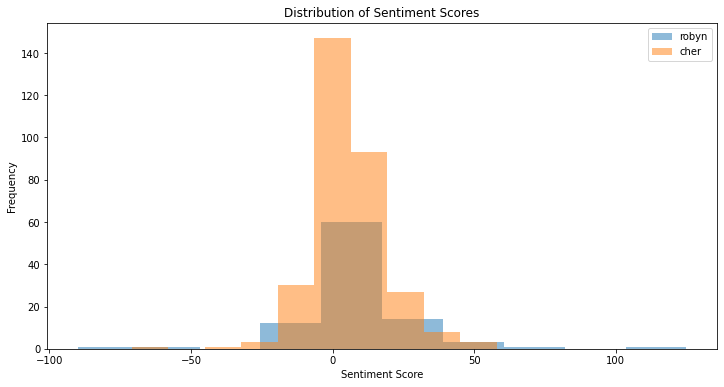

In [ ]:
# Set up the figure and axis
fig, ax = plt.subplots(figsize = (12,6))

# Plot histograms using matplotlib
ax.hist(sentiment_df.loc[sentiment_df['Artist'] == 'robyn', 'Value'].values, alpha=0.5, label='robyn')
ax.hist(sentiment_df.loc[sentiment_df['Artist'] == 'cher', 'Value'].values, alpha=0.5, label='cher')

# Set the labels and title
ax.set_xlabel('Sentiment Score')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Sentiment Scores')

# Show the legend
ax.legend()

# Display the plot
plt.show()

## Sentiment Analysis on Twitter Descriptions

In this section, define two sets of emojis you designate as positive and negative. Make sure to have at least 10 emojis per set. You can learn about the most popular emojis on Twitter at [the emojitracker](https://emojitracker.com/). 

Associate your positive emojis with a score of +1, negative with -1. Score the average sentiment of your two artists based on the Twitter descriptions of their followers. The average sentiment can just be the total score divided by number of followers. You do not need to calculate sentiment on non-emoji content for this section.

In [15]:
positive_emojis = [
    "😄", "😊", "🙂", "🥰", "🤗", "🌞", "🌟", "💖", "🎉", "🎈",
    "🌺", "🌈", "🍀", "🥳", "👏", "🙌", "🌼", "🥇", "🌻", "🎵",
    "🎶", "🎁", "🌸", "💃", "🔥", "💯", "🍓", "🥂", "🌹", "💕"
]

negative_emojis = [
    "😞", "😔", "😢", "😠", "😒", "😕", "😖", "😣", "😩", "🙁",
    "😭", "😡", "😟", "😣", "😓", "🤔", "👎", "🤬", "😳", "😑",
    "🤯", "🤢", "😴", "👿", "😤", "😪", "😫", "👿", "😾", "🤦"
]

# Create a dataframe with emojis and sentiment values
emoji_df = pd.DataFrame({
    'emoji': positive_emojis + negative_emojis,
    'sentiment': [1] * len(positive_emojis) + [-1] * len(negative_emojis)
})

Create a new dictionary of only the emojis that are present for each artist in the followers dictionary 

In [21]:
twitter_emojis = {}

# Iterate over each artist in the twitter_data dictionary
for artist, tweets in twitter_data.items():
    emojis = []

    # Iterate over each tweet of the artist
    for tweet in tweets:
        # Find all emojis in the tweet
        emoji_list = [c for c in tweet if emoji.is_emoji(c)]

        # Add the found emojis to the list
        emojis.extend(emoji_list)

    # Add the list of emojis to the dictionary for the artist
    twitter_emojis[artist] = emojis

In [24]:
twitter_data

{'cher': ['𝙿𝚛𝚘𝚞𝚍 𝚜𝚞𝚙𝚙𝚘𝚛𝚝𝚎𝚛 𝚘𝚏 𝚖𝚎𝚜𝚜𝚢 𝚋𝚞𝚗𝚜 & 𝚕𝚎𝚐𝚐𝚒𝚗𝚐𝚜',
  '163㎝／愛かっぷ💜26歳🍒 工〇好きな女の子💓 フォローしてくれたらDMします🧡',
  'csu',
  'Writer @Washinformer @SpelmanCollege alumna #DCnative Award-winning journalist & PR pro @IABC Fellow & Past Chair IG: bcscomm Email: wibsiler@gmail.com',
  'I’m unemployed and live with my parents. MOOPS!',
  'zoowee mama',
  'Let the healing begin. Let us learn from the past. 🇨🇦 follower of #TheResistance',
  'do what thou wilt. 🖤✨',
  'Curious Canadian Contemplator. She/Her. Sexagenarian. We are here for each other!',
  '(She/Her/Hers) Feminist. LGBTQ+. BLM. Mental health advocate. Do something nice for somebody today :)',
  'IG: @browsbyluz_',
  "BLM I LOVE 80'S VIVA MÉXICO",
  'Ubuntu to Mudita 🧩 INFP🌻',
  "I'm just a guy, married, kids and constantly wonder what happened to my life? I expect you to understand. Oh yeah follow me okay.",
  'Dance yourself clean. Saunas are nice too',
  'Romanos 8:31 ✝️',
  'Supporting from California, USA. Let the truth prevail.',
  'I li

twitter_data

Q: What is the average sentiment of your two artists? 

A: <!-- Your answer here --> 

---

Q: Which positive emoji is the most popular for each artist? Which negative emoji? 

A: <!-- Your answer here --> 

